In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib as mpl

In [2]:
plt.figure()
import mplhep
mplhep.style.use("CMS")
IRRADIATION_START_TIME=np.datetime64('2022-09-26 14:45')

<Figure size 432x288 with 0 Axes>

In [3]:
scanDirs=os.listdir("phaseScans/board_10/voltage_1_20")
df=pd.DataFrame({'Timestamp':scanDirs})
df['Date']=df['Timestamp'].apply(lambda x: pd.to_datetime(x,format="%d%b_%H%M%S").replace(year=2022))

df=df.loc[df.Date>'2022-09-26 12']
df.set_index('Date',inplace=True)
df.sort_index(inplace=True)

t0=((df.index-IRRADIATION_START_TIME).values).astype(int)/3.6e12
t0[t0<0]=0
TID=t0*5.51
df['TID']=TID

In [4]:
def getPhase(fName):
    try:
        x=np.loadtxt(fName,delimiter=',',dtype=int) 
    except: 
        x=np.ones(15*12,dtype=int).reshape(15,12)*255
    return x
        

capBankVals=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,24,25,26,27,28,29,30,31,56,57,58,59,60,61,62,63,120,121,122,123,124,125,126,127]    
for capSel in capBankVals:
    df[f'phaseScan_1p20V_CapSel{capSel}']=df['Timestamp'].apply(lambda x: getPhase(f'phaseScans/board_10/voltage_1_20/{x}/eRx_PhaseScan_CapSelect_{capSel}.csv'))
    df[f'phaseScan_1p08V_CapSel{capSel}']=df['Timestamp'].apply(lambda x: getPhase(f'phaseScans/board_10/voltage_1_08/{x}/eRx_PhaseScan_CapSelect_{capSel}.csv'))
    df[f'phaseScan_1p32V_CapSel{capSel}']=df['Timestamp'].apply(lambda x: getPhase(f'phaseScans/board_10/voltage_1_32/{x}/eRx_PhaseScan_CapSelect_{capSel}.csv'))

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/2107694158.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'phaseScan_1p32V_CapSel{capSel}']=df['Timestamp'].apply(lambda x: getPhase(f'phaseScans/board_10/voltage_1_32/{x}/eRx_PhaseScan_CapSelect_{capSel}.csv'))
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/2107694158.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'phaseScan_1p20V_CapSel{capSel}']=df['Timestamp'].apply(lambda x: getPhase(f'phaseScans/board_10/voltage_1_20/{x}/

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/2107694158.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'phaseScan_1p32V_CapSel{capSel}']=df['Timestamp'].apply(lambda x: getPhase(f'phaseScans/board_10/voltage_1_32/{x}/eRx_PhaseScan_CapSelect_{capSel}.csv'))


In [5]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def get_max_width(err_counts):
    max_width_by_ch = []
    second_max_width_by_ch = []
    err_wrapped=np.concatenate([err_counts,err_counts[:4]])
    for ch in range(12):
        x = err_wrapped[:,ch]
        phases = consecutive(np.argwhere(x<=1).flatten())
        sizes = [np.size(a) for a in phases]
        max_width = max(sizes)
        sizes.remove(max_width)
        try:
            second_max_width = max(sizes)
        except:
            second_max_width = 0
        max_width_by_ch.append(max_width)
        second_max_width_by_ch.append(second_max_width)
    return np.array([max_width_by_ch,second_max_width_by_ch])

def get_best_setting(err_counts):
    best_setting_by_ch = []
    counts_window = []
    for i in range(15):
        counts_window.append( err_counts[i] + err_counts[(i-1)%15] + err_counts[(i+1)%15])
    counts_window = np.array(counts_window)
    counts_window[ err_counts>0 ] += 255*3
    y = (5*err_counts[2:-2]+
         3*err_counts[1:-3]+
         3*err_counts[3:-1]+
         1*err_counts[4:] + 
         1*err_counts[:-4])
    y[ err_counts[2:-2]>0 ] += 2555
    best_setting = y.argmin(axis=0)+2
    return best_setting


In [6]:
df_bestPhase=pd.DataFrame(index=df.index)
for c in df.columns[2:]:
    df_bestPhase[c]=df[c].apply(get_best_setting)
    x=df[c].apply(get_max_width).values
    df_bestPhase[c+"_width"]=[i[0] for i in x]
    df_bestPhase[c+"_width2"]=[i[1] for i in x]


/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width"]=[i[0] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestPhase[c+"_width2"]=[i[1] for i in x]
/var/folders/67/xw3dpsz136g3dxp6m1g312hh0000gq/T/ipykernel_44085/1305049373.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [7]:
m=[]
for c in capBankVals:
    m.append(np.array(list(df_bestPhase[f'phaseScan_1p20V_CapSel{c}_width'].values)).mean(axis=1))
m=np.array(m)

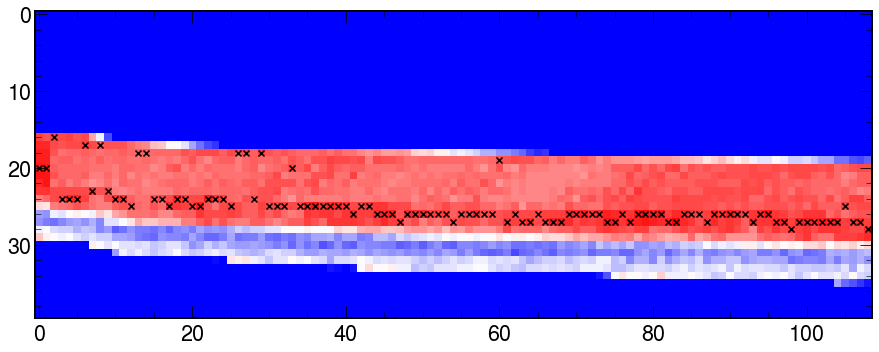

In [8]:
fig=plt.figure(figsize=(15,8))
plt.imshow(m,cmap=mpl.colormaps['bwr'])
plt.scatter(np.arange(m.shape[1]),m.argmax(axis=0),marker='x',color='k')

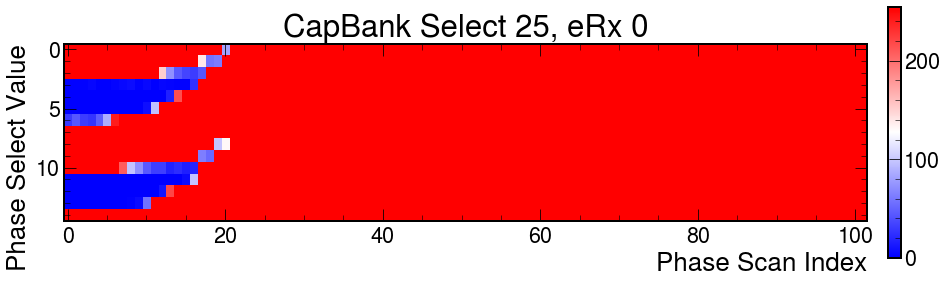

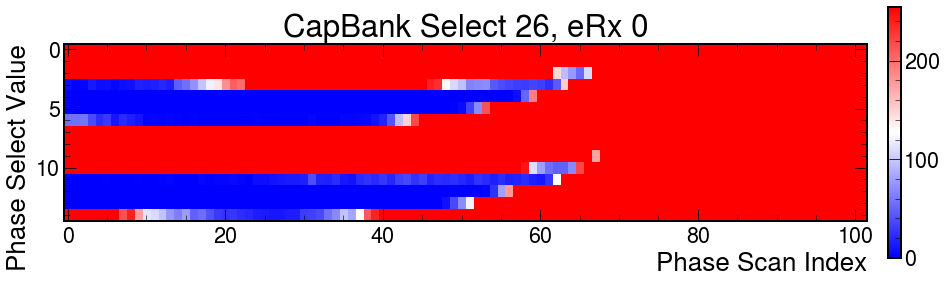

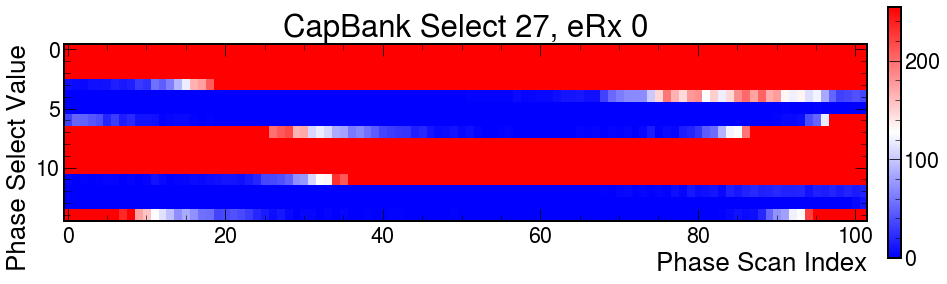

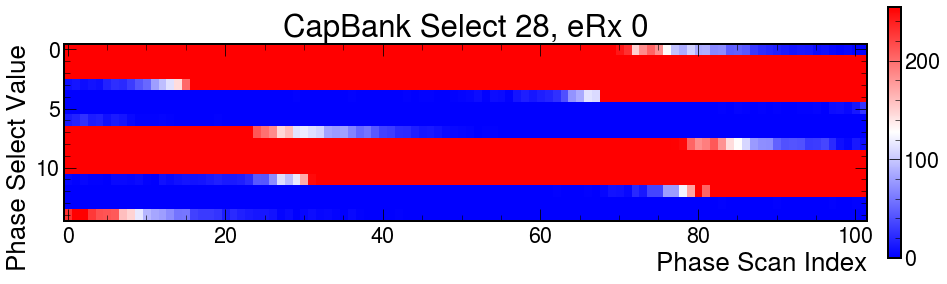

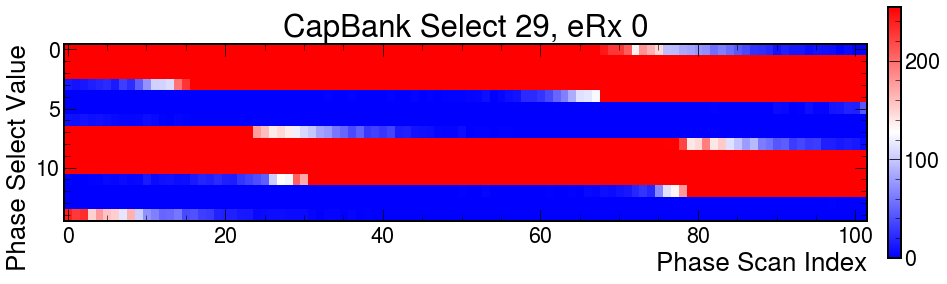

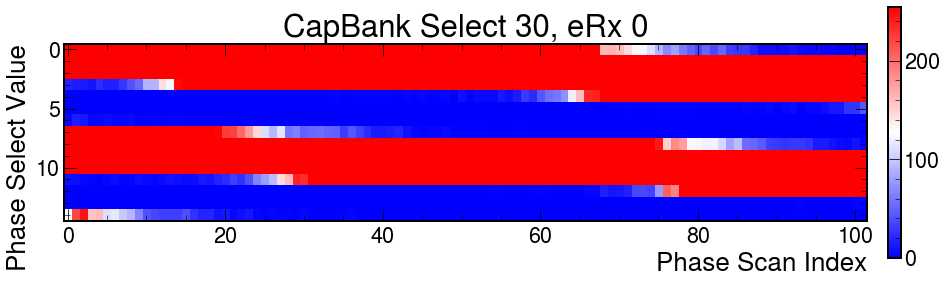

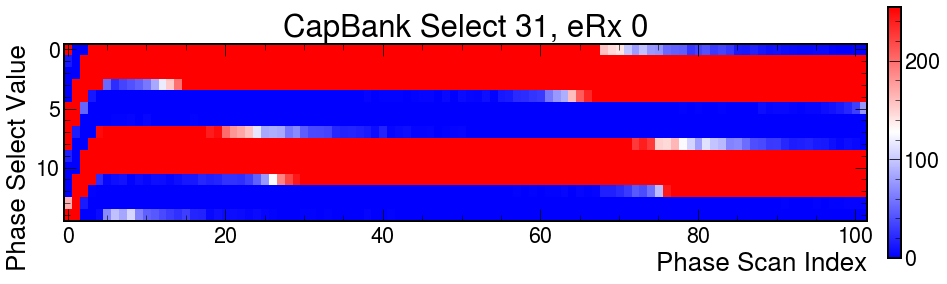

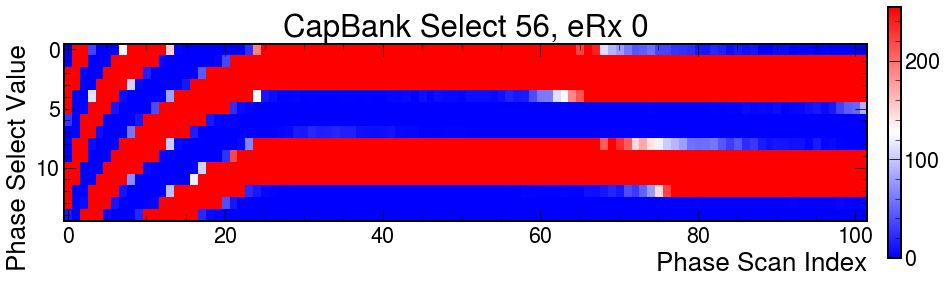

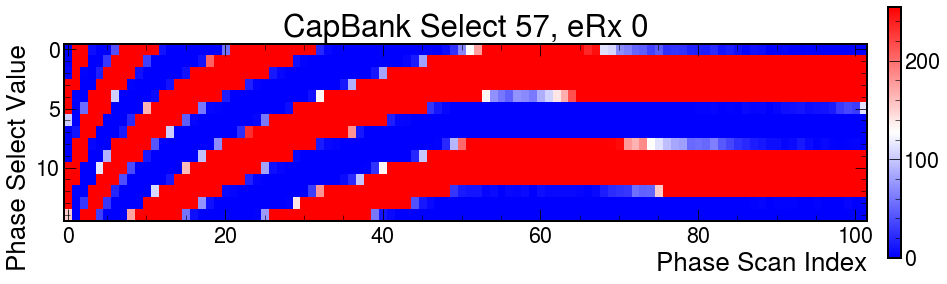

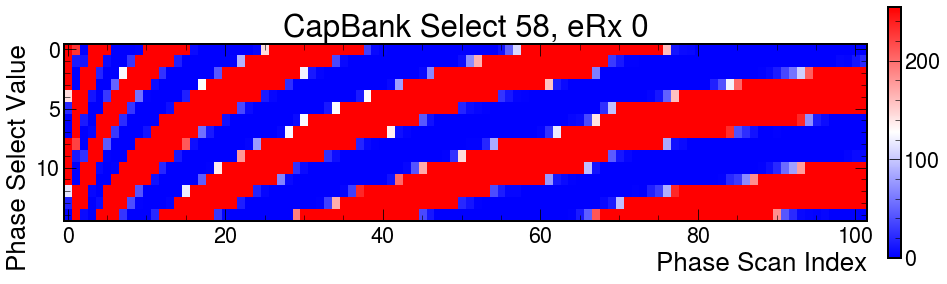

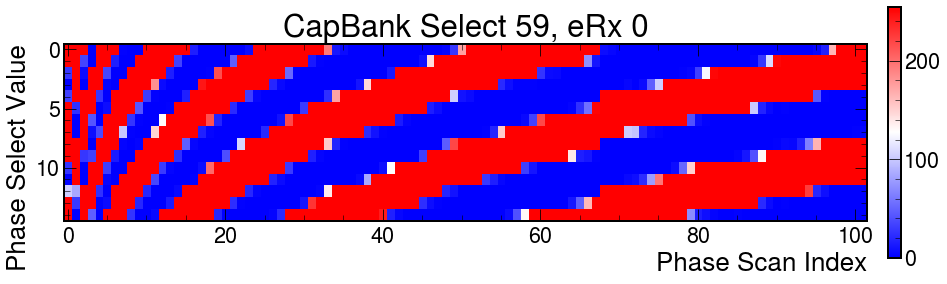

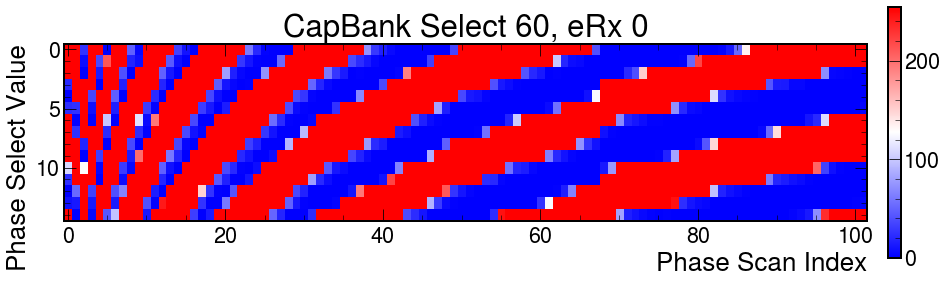

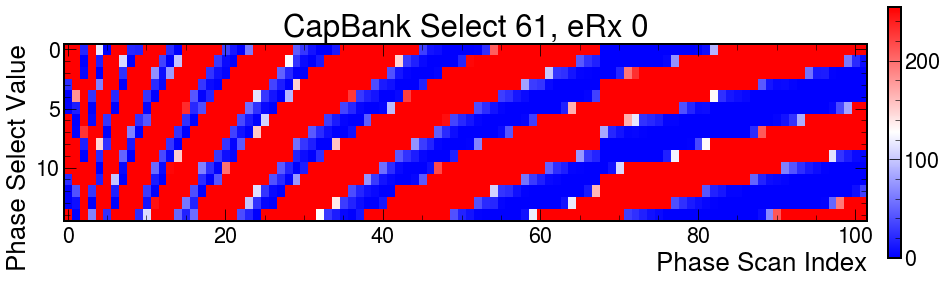

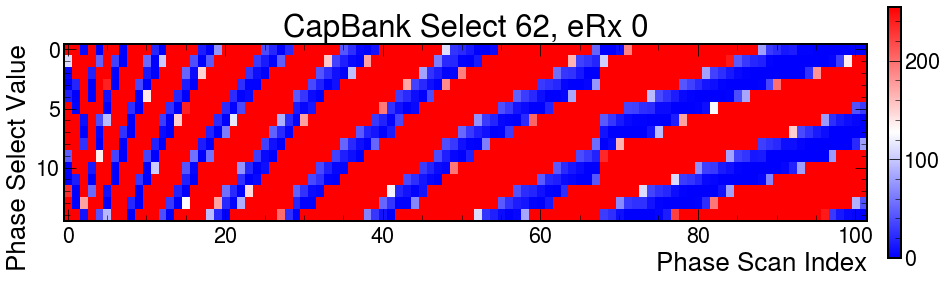

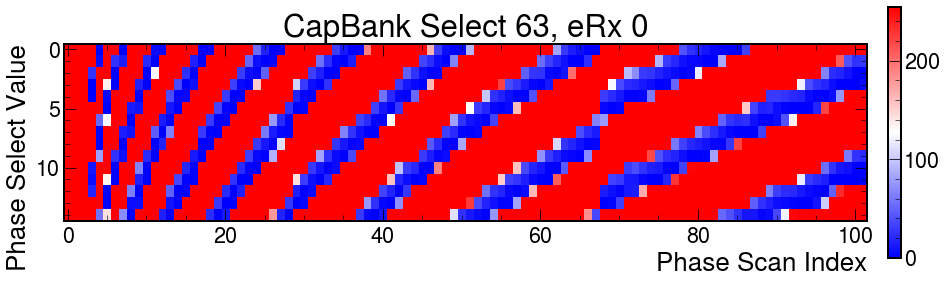

In [9]:
for i in [25,26,27,28,29,30,31,56,57,58,59,60,61,62,63]:
    x=np.array(list(df.loc['2022-09-26 14:45':][f'phaseScan_1p20V_CapSel{i}'].values))
    fig=plt.figure(figsize=(15,8))
    im=plt.imshow(x[:,:,0].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
    plt.xlabel('Phase Scan Index')
    plt.ylabel('Phase Select Value')
    plt.colorbar(fraction=0.015, pad=.025);
    plt.title(f'CapBank Select {i}, eRx 0')


In [10]:
df.loc['2022-09-26 14:45':,'TID']

Date
2022-09-26 15:03:51      1.731058
2022-09-26 15:33:32      4.456978
2022-09-26 16:02:22      7.104839
2022-09-26 16:30:47      9.714436
2022-09-26 16:59:52     12.385256
                          ...    
2022-09-28 18:17:51    284.026725
2022-09-28 18:51:19    287.100081
2022-09-28 19:23:31    290.057114
2022-09-28 19:55:39    293.008025
2022-09-28 20:27:36    295.942100
Name: TID, Length: 102, dtype: float64

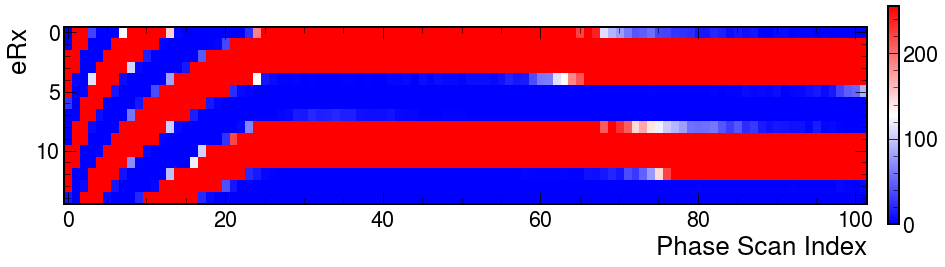

In [11]:
x=np.array(list(df.loc['2022-09-26 14:45':].phaseScan_1p20V_CapSel56.values))

fig=plt.figure(figsize=(15,4))
im=plt.imshow(x[:,:,0].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.015, pad=.025);
# plt.xticks(df.loc['2022-09-26 14:45':,'TID']);

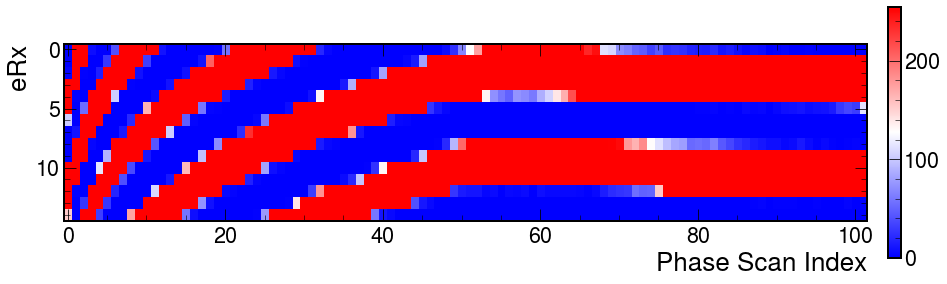

In [12]:
x=np.array(list(df.loc['2022-09-26 14:45':].phaseScan_1p20V_CapSel57.values))

fig=plt.figure(figsize=(15,8))
im=plt.imshow(x[:,:,0].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.015, pad=.025);


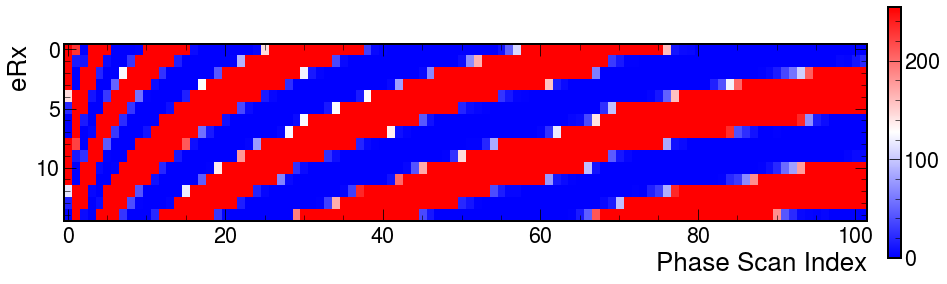

In [13]:
x=np.array(list(df.loc['2022-09-26 14:45':].phaseScan_1p20V_CapSel58.values))

fig=plt.figure(figsize=(15,8))
im=plt.imshow(x[:,:,0].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.015, pad=.025);


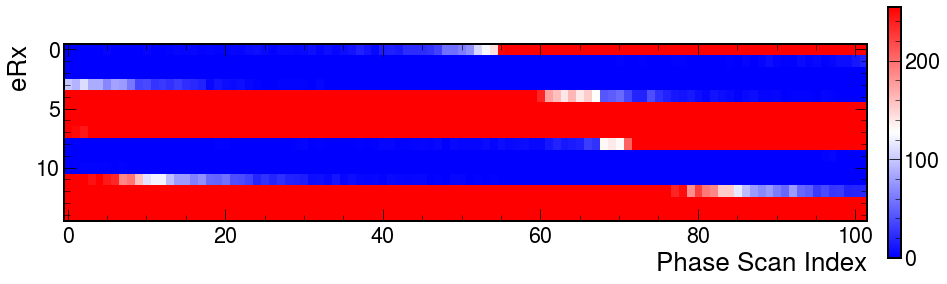

In [14]:
x=np.array(list(df.loc['2022-09-26 14:45':].phaseScan_1p32V_CapSel27.values))

fig=plt.figure(figsize=(15,8))
im=plt.imshow(x[:,:,0].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.015, pad=.025);


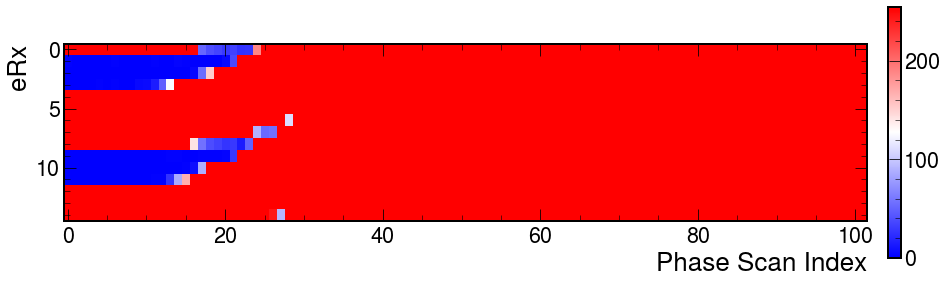

In [15]:
x=np.array(list(df.loc['2022-09-26 14:45':].phaseScan_1p08V_CapSel27.values))

fig=plt.figure(figsize=(15,8))
im=plt.imshow(x[:,:,0].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.015, pad=.025);


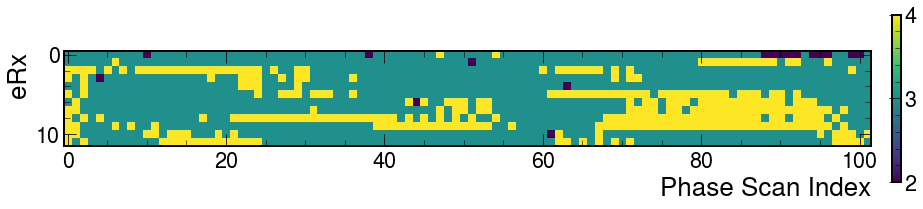

In [16]:
x=np.array(list(df_bestPhase.loc['2022-09-26 14:45':].phaseScan_1p20V_CapSel31_width.values))

fig=plt.figure(figsize=(15,5))
im=plt.imshow(x.T)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.01, pad=.025);


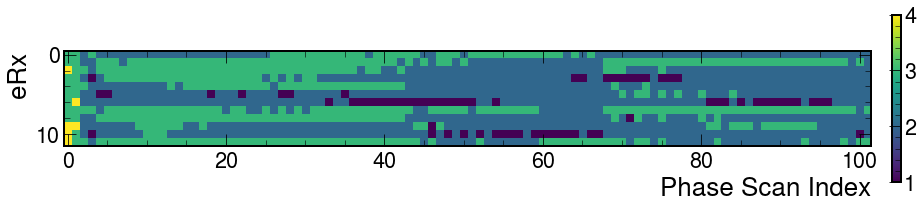

In [17]:
x=np.array(list(df_bestPhase.loc['2022-09-26 14:45':].phaseScan_1p20V_CapSel31_width2.values))

fig=plt.figure(figsize=(15,5))
im=plt.imshow(x.T)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.01, pad=.025);


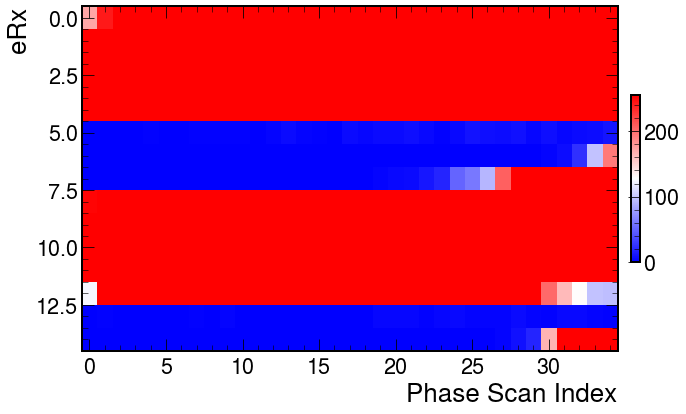

In [18]:
x=np.array(list(df.loc['2022-09-28 00':].phaseScan_1p20V_CapSel27.values))

# fig=plt.figure(figsize=(15,8))
im=plt.imshow(x[:,:,4].T,cmap=mpl.colormaps['bwr'],aspect=1.5)
plt.xlabel('Phase Scan Index')
plt.ylabel('eRx')
plt.colorbar(fraction=0.015, pad=.025);
